In [1]:
from fastai.text import *

In [2]:
df_train = pd.read_csv('../data/data_clean/train.csv')
df_val = pd.read_csv('../data/data_clean/val.csv')

In [3]:
df_val.head()

,text,airline_sentiment
0,@USAirways : i was told my ticket expired but ...,negative
1,@USAirways on hold 2.5 hrs trying to reschedul...,negative
2,@AmericanAir I didn't miss my flight. America...,negative
3,@united I would like 2 speak @United VP of #Cu...,negative
4,@JetBlue what's up w flt 4? Brothers fiancé si...,negative


In [24]:
data_lm = TextLMDataBunch.from_df('../data/data_clean', df_train, df_val, text_cols=0, bs=32)
data_clas = TextClasDataBunch.from_df('../data/data_clean', df_train, df_val, text_cols=0, label_cols=1, bs=32)
data_clas.save('data_clas.pkl')

# 1. Language model

In [5]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, pretrained=True, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


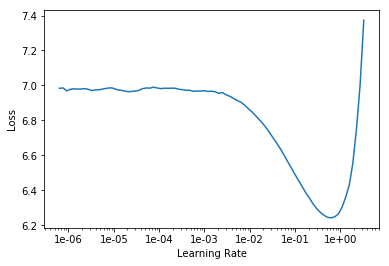

In [6]:
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.578076,4.101927,0.246819,00:15


In [8]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


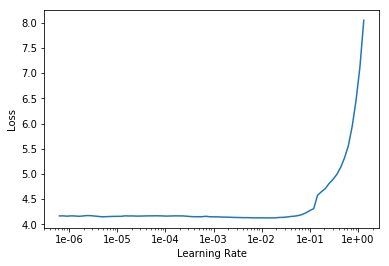

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.065042,3.967928,0.265290,00:19
1,3.924886,3.846084,0.277316,00:20
2,3.766963,3.761123,0.286747,00:20
3,3.569597,3.713048,0.291936,00:20
4,3.390167,3.714445,0.288756,00:20
5,3.195561,3.708465,0.293722,00:20
6,3.018237,3.734534,0.292913,00:20
7,2.876020,3.758329,0.291685,00:20
8,2.786686,3.776537,0.292160,00:20
9,2.742861,3.780856,0.291769,00:20


In [11]:
learn.save('twitter-sentiment-lm')

In [12]:
TEXT = "I didn't like "
N_WORDS = 40
N_SENTENCES = 2

In [13]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I didn't like  this ! Its a solid and sale tickets . You need an on - time US Air credit . xxbos @jetblue when will this happen ? If there is anything i can do to be
I didn't like  Southwest ! Thank you ! xxbos @jetblue Flying from Miami to Newark , NJ , on Thursday . Can i get a better seat from AA ? xxbos @americanair After


In [14]:
learn.save_encoder('twitter-sentiment-enc')

# 2. Classifier

In [15]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, pretrained=True, drop_mult=0.3)
learn.load_encoder('twitter-sentiment-enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


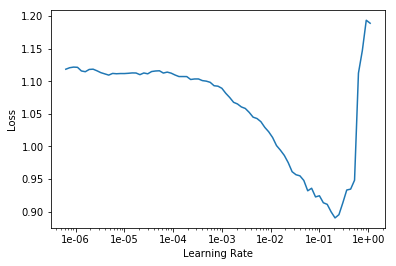

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.597419,0.493470,0.804138,00:11


In [18]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.587158,0.487054,0.797241,00:12


In [19]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.503631,0.413082,0.837241,00:21


In [20]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.431188,0.407140,0.835862,00:27
1,0.411089,0.433805,0.833103,00:25


In [21]:
learn.predict(" I loved my flight")

(Category positive, tensor(2), tensor([0.0151, 0.0072, 0.9777]))

Save the model:

In [23]:
learn.save('twitter-sentiment-classifier')

Loading the classifier back:

In [12]:
df_train = pd.read_csv('../data/data_clean/train.csv')
df_val = pd.read_csv('../data/data_clean/val.csv')
data_clas = TextClasDataBunch.from_df('../data/data_clean', df_train, df_val, text_cols=0, label_cols=1, bs=32)
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, pretrained=True, drop_mult=0.3)
learn.load('twitter-sentiment-classifier')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11726 items)
x: TextList
xxbos @southwestair i 'm on the 10:55 flight ! xxmaj everyone has been so nice and helpful ! i 'm just hoping we 'll get to fly out ! xxmaj thank you ! ;),xxbos @jetblue your agents at xxup iad have xxunk this problem by not making any announcements # xxunk,xxbos @jetblue xxmaj has xxup dc xxmaj thinking xxmaj about xxmaj summer xxmaj with xxmaj new xxmaj nantucket xxmaj service - xxunk http : / / t.co / xxunk,xxbos @united how else would i know it was denied ?,xxbos @united we needed them here asap . xxmaj will they make it on today 's flight ?
y: CategoryList
positive,negative,neutral,negative,negative
Path: ../data/data_clean;

Valid: LabelList (1450 items)
x: TextList
xxbos @usairways : i was told my ticket expired but i never xxunk any notice before it expired xxunk xxunk paid xxunk miles & & $ xxunk for the xxunk,xxbos @usairways on hold 2.5 hrs trying to reschedule our flight . xxmaj can anyone there 

In [13]:
learn.predict('I loved my flight')

(Category positive, tensor(2), tensor([0.0238, 0.0175, 0.9587]))